In [1]:
# Импорт библиотек
import os
import time
import KU_TU
import GTU
import mat_properties as prop
import numpy as n
import pandas as pd
from scipy.optimize import root

# таблица номинального режима
gas_streams0 = pd.read_excel("streams0.xlsx", sheet_name="gas", index_col=0)
water_streams0 = pd.read_excel(
    "streams0.xlsx", sheet_name="water", index_col=0)
GTU_ISO = pd.read_excel("input.xlsx", sheet_name="ISO", index_col=0)
GTU_input = pd.read_excel("input.xlsx", sheet_name="GTU_input", index_col=0)
# рабочая таблица (=номинал в 1 итерации)
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
water_streams = pd.read_excel("streams.xlsx", sheet_name="water", index_col=0)
# рабочая таблица показателей блоков
heaters = pd.read_excel("blocks.xlsx", sheet_name="heaters", index_col=0)
electric = pd.read_excel("blocks.xlsx", sheet_name="electric", index_col=0)

# Состав газов в номинале
gasmix = "Nitrogen*Oxygen*CO2*Water*Argon"
# Считывание рефпропа
RP = prop.init_REFPROP(r"C:\Program Files (x86)\REFPROP")
fractiongas0 = (
    gas_streams0.at["GTU-PEVD", "N2"],
    gas_streams0.at["GTU-PEVD", "O2"],
    gas_streams0.at["GTU-PEVD", "CO2"],
    gas_streams0.at["GTU-PEVD", "H2O"],
    gas_streams0.at["GTU-PEVD", "Ar"],
)

gas0 = prop.Materials_prop(
    gasmix,
    fractiongas0,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    RP=RP,
)
water = prop.Materials_prop(
    "water",
    [1.0, 0, 0, 0, 0],
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    RP=RP,
)


# Задание энтальпий газа в номинальном режиме
Temperatures = gas_streams0.loc["GTU-KU":"GPK-out", "T"]
Pressure = gas_streams0.loc["GTU-KU", "P"]
Enthalpies = list(map(lambda x: gas0.p_t(Pressure, x)["h"], Temperatures))
gas_streams0.loc["GTU-KU":"GPK-out", "H"] = Enthalpies


####################################################################################################
# Расчет ГТУ
Gas_turbine = GTU.gtu(GTU_ISO, GTU_input, "GTU-KU")
Gas_turbine_res = Gas_turbine.calc()
electric.at["GTU", "N"] = Gas_turbine_res["N"]
electric.at["GTU", "KPD"] = Gas_turbine_res["eff"]
electric.at["DK", "N"] = Gas_turbine_res["Ndk"]
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
gas_streams.at["GTU-KU", "T"] = Gas_turbine_res["T"]
gas_streams.at["GTU-KU", "G"] = Gas_turbine_res["G"]
gas_streams.at["GTU-KU", "P"] = 0.1
gas_streams.at['GTU-KU', 'H'] = gas0.p_t(
    gas_streams.at['GTU-KU', 'P'], gas_streams.at['GTU-KU', 'T'])['h']
Gas_turbine_composition = pd.read_excel(
    "input.xlsx", sheet_name="Gas_composition0", index_col=0)

# Параметры газа на выходе в КУ
gas_streams.loc["GTU-PEVD", "T":"P"] = gas_streams.loc["GTU-KU", "T":"P"]
gas_streams.at["GTU-PEVD", "G"] = gas_streams.loc["GTU-KU", "G"]
gas_streams.at["GTU-PEVD",
               "N2":"Ar"] = Gas_turbine_composition.loc["Fraction", "N2":"Ar"]

# Состав газов при частичной нагрузке
fractiongas = (
    gas_streams.at["GTU-PEVD", "N2"],
    gas_streams.at["GTU-PEVD", "O2"],
    gas_streams.at["GTU-PEVD", "CO2"],
    gas_streams.at["GTU-PEVD", "H2O"],
    gas_streams.at["GTU-PEVD", "Ar"],
)
gas1 = prop.Materials_prop(
    gasmix,
    fractiongas,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    RP=RP,
)

# Основные константы
Calcmethod = "hybr"
KPD_PN = 0.8074
KPD_KN = 0.75
KPD_to = 0.99
KPD_SP = 0.9

Calctolerance = 10**-2
Teplo = 1
Maxiterations_KU_TU = 20
Maxiterations_cotel = 5
Maxiterations_turbine = 30

#Claas KU+TU
KU_and_TU=KU_TU.ku_tu(gas0, gas1,  water, gas_streams0, gas_streams, water_streams0, water_streams, heaters, electric,Calcmethod, KPD_SP, KPD_KN, KPD_to, KPD_PN)

start_time = time.time()

KU_and_TU.calculate(Teplo,Calctolerance,Maxiterations_KU_TU,Maxiterations_cotel,Maxiterations_turbine)

print("Степень сухости пара в ЭВД: ", water.p_h(
    water_streams.at["EVD-IVD", "P"], water_streams.at["EVD-IVD", "H"])["Q"],)
print("Степень сухости пара в ГПК: ", water.p_h(
    water_streams.at["GPK-IND", "P"], water_streams.at["GPK-IND", "H"])["Q"],)

print(f"fin КУ и ТУ:--- {round((time.time() - start_time), 1)} сек. ---")

Достигнуто максимальное количество итераций контура высокого давления
Fin котел-утилизатора:--- 19.74 сек. ---
dQ/Qsumm -0.038063200576156066
Fin турбоустановка:--- 0.06 сек. ---
Fin котел-утилизатора:--- 4.68 сек. ---
dQ/Qsumm -0.00949281333161535
Fin турбоустановка:--- 0.06 сек. ---
Fin котел-утилизатора:--- 2.46 сек. ---
dQ/Qsumm -0.006525460278746825
Fin турбоустановка:--- 0.04 сек. ---
Максимальная погрешность определения расхода в КУ+ПТУ 0.01640495077866173
Pnd_it [0.46476]
Pvd_it [5.62565]
Время 1 итерации расчета КУ+ТУ:--- %s сек. --- 27.0
Fin котел-утилизатора:--- 6.87 сек. ---
dQ/Qsumm -0.08064259614660718
Fin турбоустановка:--- 0.04 сек. ---
Fin котел-утилизатора:--- 2.97 сек. ---
dQ/Qsumm -0.02967569711879382
Fin турбоустановка:--- 0.05 сек. ---
Fin котел-утилизатора:--- 2.53 сек. ---
dQ/Qsumm 0.011029260353855961
Fin турбоустановка:--- 0.04 сек. ---
Максимальная погрешность определения расхода в КУ+ПТУ 0.05338012486402444
Pnd_it [0.46476, 0.46149]
Pvd_it [5.62565, 5.50783]

In [2]:
# Вывод газовых потоков
gas_streams

,T,P,H,G,N2,O2,CO2,H2O,Ar
AIR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTU-KU,509.892416,0.1,921.662785,354.05446,0.7803,0.1237,0.0301,0.0594,0.0065
GTU-PEVD,509.892416,0.1,921.662785,354.05446,0.7803,0.1237,0.0301,0.0594,0.0065
PEVD-IVD,444.434393,0.1,847.353298,354.05446,0.7803,0.1237,0.0301,0.0594,0.0065
IVD-EVD,278.279006,0.1,663.793651,354.05446,0.7803,0.1237,0.0301,0.0594,0.0065
EVD-PPND,220.666989,0.1,601.745065,354.05446,0.7803,0.1237,0.0301,0.0594,0.0065
PPND-IND,217.742078,0.1,598.614476,354.05446,0.7803,0.1237,0.0301,0.0594,0.0065
IND-GPK,158.427547,0.1,535.494955,354.05446,0.7803,0.1237,0.0301,0.0594,0.0065
GPK-out,101.702590,0.1,475.695718,354.05446,0.7803,0.1237,0.0301,0.0594,0.0065


In [3]:
# Вывод водяных потоков
water_streams

,T,P,H,G,S,X
AIR,15.000000,NaN,NaN,NaN,NaN,NaN
PEVD-DROSVD,495.440778,5.474182,3418.464971,41.288075,NaN,NaN
IVD-PEVD,272.333829,5.706690,2787.674749,41.288075,NaN,NaN
EVD-IVD,272.333829,5.706690,1229.380594,41.288075,NaN,NaN
PEN-EVD,165.555896,5.706690,702.493027,41.288075,NaN,NaN
BND-PEN,149.629970,0.471460,630.582969,41.288075,NaN,NaN
PPND-DROSND,191.230398,0.466527,2838.817211,11.756442,NaN,NaN
IND-PPND,149.629970,0.471460,2745.480243,11.756442,NaN,NaN
GPK-IND,149.629970,0.471460,682.200733,53.044517,NaN,NaN
GPK-REC,149.629970,0.471460,682.200733,53.044517,NaN,NaN


In [4]:
Errors_water = abs(water_streams - water_streams0)/water_streams0*100
Errors_gas = abs(gas_streams-gas_streams0)/gas_streams0*100
Errors_gas
Errors_water

,G,H,P,S,T,X
AIR,NaN,NaN,NaN,NaN,NaN,NaN
BND-PEN,34.876853,9.411437,32.300361,NaN,9.171143,NaN
DOOTB1,52.541211,0.445036,37.614373,2.517122,NaN,NaN
DOOTB2,32.133422,1.382921,47.364840,2.737845,17.843311,NaN
DROSND-TURBND,20.349307,1.135663,35.512805,1.829012,9.749953,NaN
DROSVD-TURBVD,34.876853,0.118640,34.885713,NaN,2.947697,NaN
ENDOFVD,34.876853,0.149019,35.394806,NaN,3.550792,NaN
EVD-IVD,34.876853,8.114489,34.750861,NaN,8.857487,NaN
GPK-BYPASS,NaN,NaN,NaN,NaN,NaN,NaN
GPK-IND,32.133422,1.911299,32.300361,NaN,9.094793,NaN


In [5]:
gas_streams0

,T,P,H,G,N2,O2,CO2,H2O,Ar
GTU-KU,542.10,0.1,958.637030,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
GTU-PEVD,542.10,0.1,958.637030,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
PEVD-IVD,468.05,0.1,874.031830,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
IVD-EVD,309.20,0.1,697.417326,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
EVD-PPND,235.90,0.1,618.078812,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
PPND-IND,233.00,0.1,614.965387,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
IND-GPK,175.50,0.1,553.594555,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
GPK-out,106.90,0.1,481.155410,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
water_streams0

,T,P,H,G,S
PEVD-DROSVD,511.500000,8.407000,3423.209978,63.400000,NaN
IVD-PEVD,301.297556,8.746000,2747.104023,63.400000,NaN
EVD-IVD,298.800000,8.746000,1337.948265,63.400000,NaN
PEN-EVD,166.500000,8.746000,708.319849,63.400000,NaN
BND-PEN,164.738361,0.696400,696.095567,63.400000,NaN
PPND-DROSND,211.600000,0.691000,2871.481837,14.760000,NaN
IND-PPND,164.738361,0.696400,2762.534980,14.760000,NaN
GPK-IND,164.600000,0.696400,695.493701,78.160000,NaN
GPK-REC,164.600000,0.696400,695.493701,82.910000,NaN
REC-GPK,60.000000,0.696400,251.748396,82.910000,NaN


In [7]:
electric

,Ni,N,KPDm,KPD
PEN,2.969028,3.643294,0.814930,0.079257
CVD,NaN,NaN,NaN,NaN
CND,NaN,NaN,NaN,NaN
GTU,NaN,82.830000,NaN,28.111134
DK,NaN,6.125634,NaN,NaN
Turbine,34.180886,NaN,NaN,NaN
Tots1,23.881781,NaN,NaN,NaN
Tots2,8.094342,NaN,NaN,NaN
Tots3,0.462051,NaN,NaN,NaN
Tots4,1.742710,NaN,NaN,NaN


In [8]:
heaters

,Qw,Qg,KPD
PEVD,26046.509502,26309.605558,0.99
IVD,64340.210561,64990.111678,0.99
EVD,21748.892507,21968.578290,0.99
PPND,1097.315267,1108.399260,0.99
IND,22124.270268,22347.747745,0.99
GPK,20960.464706,21172.186571,0.99
SP2,32.167208,NaN,0.90
SP1,65.930955,NaN,0.90
OD,4.483336,NaN,0.90


In [9]:
GTU_input

,1,2,3,4,5,6
tair,-40.0,NaN,NaN,NaN,NaN,NaN
n,0.5,NaN,NaN,NaN,NaN,NaN
Pin,0.0,NaN,NaN,NaN,NaN,NaN
Pout,0.0,NaN,NaN,NaN,NaN,NaN


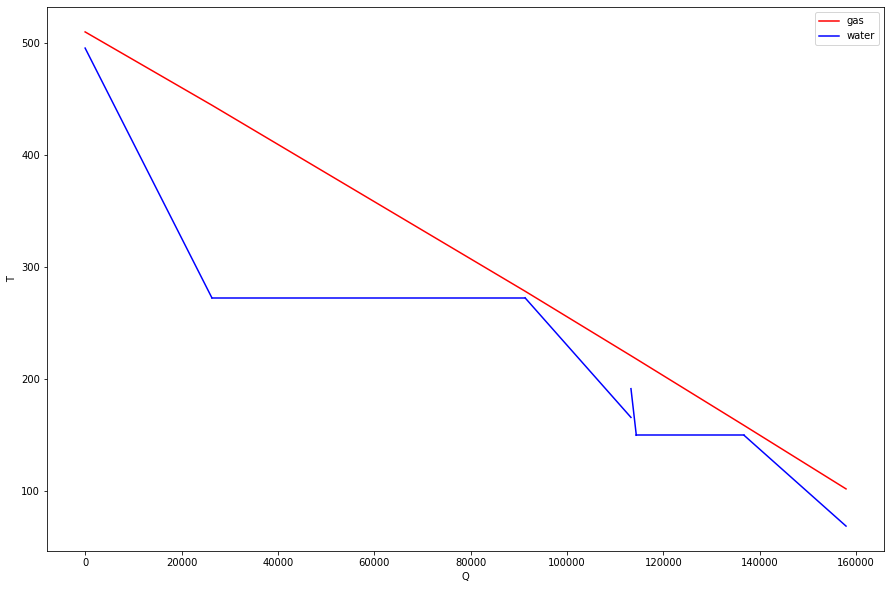

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
Qg = [0,
      heaters.loc['PEVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'] +
      heaters.loc['EVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'] +
      heaters.loc['EVD', 'Qg']+heaters.loc['PPND', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg']+heaters.loc['EVD',
                                                                     'Qg']+heaters.loc['PPND', 'Qg']+heaters.loc['IND', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg']+heaters.loc['EVD', 'Qg'] +
      heaters.loc['PPND', 'Qg'] +
      heaters.loc['IND', 'Qg']+heaters.loc['GPK', 'Qg']
      ]
Qw = [0,
      heaters.loc['PEVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'] +
      heaters.loc['EVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'] +
      heaters.loc['EVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'] +
      heaters.loc['EVD', 'Qg']+heaters.loc['PPND', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg']+heaters.loc['EVD',
                                                                     'Qg']+heaters.loc['PPND', 'Qg']+heaters.loc['IND', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg']+heaters.loc['EVD',
                                                                     'Qg']+heaters.loc['PPND', 'Qg']+heaters.loc['IND', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg']+heaters.loc['EVD', 'Qg'] +
      heaters.loc['PPND', 'Qg'] +
      heaters.loc['IND', 'Qg']+heaters.loc['GPK', 'Qg']
      ]
Tg = gas_streams.loc['GTU-PEVD':'GPK-out', 'T']
Tw = [water_streams.loc['PEVD-DROSVD', 'T'],
      water_streams.loc['IVD-PEVD', 'T'],
      water_streams.loc['IVD-PEVD', 'T'],
      water_streams.loc['EVD-IVD', 'T'],
      water_streams.loc['PEN-EVD', 'T'],
      water_streams.loc['PPND-DROSND', 'T'],
      water_streams.loc['IND-PPND', 'T'],
      water_streams.loc['IND-PPND', 'T'],
      water_streams.loc['GPK-REC', 'T'],
      water_streams.loc['REC-GPK', 'T'],
      ]
plt.plot(Qg, Tg, color='red')
plt.plot(Qw[0:2], Tw[0:2], color='blue')
plt.plot(Qw[1:3], Tw[1:3], color='blue')
plt.plot(Qw[3:5], Tw[3:5], color='blue')
plt.plot(Qw[5:7], Tw[5:7], color='blue')
plt.plot(Qw[6:8], Tw[6:8], color='blue')
plt.plot(Qw[8:10], Tw[8:10], color='blue')
plt.xlabel('Q')
plt.ylabel('T')
plt.legend(['gas', 'water'])
plt.show()

In [11]:
# # Импорт библиотек
# import os
# import time
# import cotel
# import Turboustanovka
# import GTU
# import mat_properties as prop
# import numpy as n
# import pandas as pd
# from scipy.optimize import root

# # таблица номинального режима
# gas_streams0 = pd.read_excel("streams0.xlsx", sheet_name="gas", index_col=0)
# water_streams0 = pd.read_excel(
#     "streams0.xlsx", sheet_name="water", index_col=0)
# GTU_ISO = pd.read_excel("input.xlsx", sheet_name="ISO", index_col=0)
# GTU_input = pd.read_excel("input.xlsx", sheet_name="GTU_input", index_col=0)
# # рабочая таблица (=номинал в 1 итерации)
# gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
# water_streams = pd.read_excel("streams.xlsx", sheet_name="water", index_col=0)
# # рабочая таблица показателей блоков
# heaters = pd.read_excel("blocks.xlsx", sheet_name="heaters", index_col=0)
# electric = pd.read_excel("blocks.xlsx", sheet_name="electric", index_col=0)

# # Состав газов в номинале
# gasmix = "Nitrogen*Oxygen*CO2*Water*Argon"
# # Считывание рефпропа
# RP = prop.init_REFPROP(r"C:\Program Files (x86)\REFPROP")
# fractiongas0 = (
#     gas_streams0.at["GTU-PEVD", "N2"],
#     gas_streams0.at["GTU-PEVD", "O2"],
#     gas_streams0.at["GTU-PEVD", "CO2"],
#     gas_streams0.at["GTU-PEVD", "H2O"],
#     gas_streams0.at["GTU-PEVD", "Ar"],
# )

# gas0 = prop.Materials_prop(
#     gasmix,
#     fractiongas0,
#     prop.REFPROP_h_s,
#     prop.REFPROP_p_t,
#     prop.REFPROP_p_h,
#     prop.REFPROP_p_s,
#     prop.REFPROP_p_q,
#     prop.REFPROP_t_q,
#     prop.REFPROP_p_rho,
#     RP=RP,
# )
# water = prop.Materials_prop(
#     "water",
#     [1.0, 0, 0, 0, 0],
#     prop.REFPROP_h_s,
#     prop.REFPROP_p_t,
#     prop.REFPROP_p_h,
#     prop.REFPROP_p_s,
#     prop.REFPROP_p_q,
#     prop.REFPROP_t_q,
#     prop.REFPROP_p_rho,
#     RP=RP,
# )


# # Задание энтальпий газа в номинальном режиме
# Temperatures = gas_streams0.loc["GTU-KU":"GPK-out", "T"]
# Pressure = gas_streams0.loc["GTU-KU", "P"]
# Enthalpies = list(map(lambda x: gas0.p_t(Pressure, x)["h"], Temperatures))
# gas_streams0.loc["GTU-KU":"GPK-out", "H"] = Enthalpies


# ####################################################################################################
# # Расчет ГТУ
# Gas_turbine = GTU.gtu(GTU_ISO, GTU_input, "GTU-KU")
# Gas_turbine_res = Gas_turbine.calc()
# electric.at["GTU", "N"] = Gas_turbine_res["N"]
# electric.at["GTU", "KPD"] = Gas_turbine_res["eff"]
# electric.at["DK", "N"] = Gas_turbine_res["Ndk"]
# gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
# gas_streams.at["GTU-KU", "T"] = Gas_turbine_res["T"]
# gas_streams.at["GTU-KU", "G"] = Gas_turbine_res["G"]
# gas_streams.at["GTU-KU", "P"] = 0.1
# gas_streams.at['GTU-KU', 'H'] = gas0.p_t(
#     gas_streams.at['GTU-KU', 'P'], gas_streams.at['GTU-KU', 'T'])['h']
# Gas_turbine_composition = pd.read_excel(
#     "input.xlsx", sheet_name="Gas_composition0", index_col=0)

# # Параметры газа на выходе в КУ
# gas_streams.loc["GTU-PEVD", "T":"P"] = gas_streams.loc["GTU-KU", "T":"P"]
# gas_streams.at["GTU-PEVD", "G"] = gas_streams.loc["GTU-KU", "G"]
# gas_streams.at["GTU-PEVD",
#                "N2":"Ar"] = Gas_turbine_composition.loc["Fraction", "N2":"Ar"]

# # Состав газов при частичной нагрузке
# fractiongas = (
#     gas_streams.at["GTU-PEVD", "N2"],
#     gas_streams.at["GTU-PEVD", "O2"],
#     gas_streams.at["GTU-PEVD", "CO2"],
#     gas_streams.at["GTU-PEVD", "H2O"],
#     gas_streams.at["GTU-PEVD", "Ar"],
# )
# gas1 = prop.Materials_prop(
#     gasmix,
#     fractiongas,
#     prop.REFPROP_h_s,
#     prop.REFPROP_p_t,
#     prop.REFPROP_p_h,
#     prop.REFPROP_p_s,
#     prop.REFPROP_p_q,
#     prop.REFPROP_t_q,
#     prop.REFPROP_p_rho,
#     RP=RP,
# )

# # Основные константы
# Calcmethod = "hybr"
# KPDnasos = 0.8074
# KPD = 0.99
# Calctolerance = 10**-2
# Teplo = 1
# Maxiterations_cotel = 10
# Maxiterations_KU_TU = 20
# Maxiterations_turbine = 30

# ####################################################################################################
# # Инициализируем все
# TU = Turboustanovka.turboustanovka(
#     water, water_streams0, water_streams, heaters, electric, KPD_SP=0.99, KPDnasos=0.8)
# Whole_cotel = cotel.cotel_all(KPD, KPDnasos,  gas0, gas1, water, Calcmethod,
#                               gas_streams0, water_streams0, gas_streams, water_streams, heaters, electric)


# Vvd0 = 1/water.p_h(water_streams0.at["PEVD-DROSVD", 'P'],
#                    water_streams0.at["PEVD-DROSVD", 'H'])['rho']
# Vnd0 = 1/water.p_h(water_streams0.at["PPND-DROSND", 'P'],
#                    water_streams0.at["PPND-DROSND", 'H'])['rho']
# Gvd0 = water_streams0.at["PEVD-DROSVD", 'G']
# Gnd0 = water_streams0.at["PPND-DROSND", 'G']
# dPvd0 = water_streams0.at["PEVD-DROSVD", 'P'] - \
#     water_streams0.at["DROSVD-TURBVD", 'P']
# dPnd0 = water_streams0.at["PPND-DROSND", 'P'] - \
#     water_streams0.at["DROSND-TURBND", 'P']

# ####################################################################################################
# # Расчет всего
# Pnd_it = []
# Pvd_it = []
# start_time = time.time()
# Max_error_P = 2
# Max_error_G = 2
# Max_error = 2
# Error_nd_P = 2
# Error_vd_P = 2
# Calctolerance_new = 10**-1
# Teplo_overflow = 0

# #Первое приближение по давлению
# G_gas1 = gas_streams.at["GTU-PEVD", "G"]
# G_gas0 = gas_streams0.at["GTU-PEVD", "G"]
# g_gas = G_gas1/G_gas0
# Pvd_1 = 0.4538+7.7601*g_gas
# Pnd_1 = -0.0189+0.6885*g_gas
# water_streams.at["PPND-DROSND", 'P'] = Pnd_1
# water_streams.at["PEVD-DROSVD", 'P'] = Pvd_1
# print('Pnd_1', Pnd_1)
# print('Pvd_1', Pvd_1)

# for i in range(Maxiterations_KU_TU):

#     for j in range(Maxiterations_cotel):

#         # Расчет котла
#         Whole_cotel.calc(Calctolerance_new, Maxiterations_cotel)
#         # print('КУ расчитан')

#         Gnd1 = water_streams.at["PPND-DROSND", "G"]
#         Gnd2 = water_streams.at["DROSND-TURBND", "G"]
#         Gvd1 = water_streams.at["PEVD-DROSVD", "G"]
#         Gvd2 = water_streams.at["DROSVD-TURBVD", "G"]

#         # Перекидываем расходы
#         water_streams.at["DROSVD-TURBVD", 'G'] = Gvd1
#         water_streams.at["DROSND-TURBND", 'G'] = Gnd1

#         # Перекидываем энтальпии
#         water_streams.at["DROSVD-TURBVD",
#                          'H'] = water_streams.at["PEVD-DROSVD", 'H']
#         water_streams.at["DROSND-TURBND",
#                          'H'] = water_streams.at["PPND-DROSND", 'H']
#         if i > 0 and Teplo == 1:
#             teplofikacia = 1
#         else:
#             teplofikacia = 0
#         # Расчет турбины
#         TU_res = TU.calculate(
#             teplofikacia, calcmethod="hybr", calctolerance=Calctolerance_new, maxiterations=Maxiterations_turbine
#         )
#         # print('ТУ рассчитана')

#         # основные потоки, которые надо сводить по расходу
#         # Calctolerance_new=Calctolerance
#         # if Max_error > 0.1 and Max_error <= 1:
#         #     print('Max_error', 0.01)
#         #     Calctolerance_new = Calctolerance*10
#         # if Max_error > 1:
#         #     print('Max_error', 1)
#         Calctolerance_new = Calctolerance*10
#         if  i>2:
#             print('Переход к оригинально точности расчета',Calctolerance)
#             Calctolerance_new = Calctolerance
#         # if Max_error_P < Calctolerance:
#         #     print('Max_error_10', 0.01)
#         #     Calctolerance_new = Calctolerance
#         # if Max_error < 0.01:
#         #     print('Max_error', 'else')
#         #     Calctolerance_new = Calctolerance

#         Error_water_G = abs((water_streams.at["SMESHOD-REC", "G"] -
#                              water_streams.at["GPK-IND", "G"])/water_streams.at["GPK-IND", "G"]*100)
#         Error_nd_G = abs((Gnd1 - Gnd2)/Gnd1*100)
#         Error_vd_G = abs((Gvd1 - Gvd2)/Gvd1*100)
#         Max_error_G = max(Error_water_G, Error_nd_G, Error_vd_G)
#         Max_error = max(Error_water_G, Error_nd_G,
#                         Error_vd_G, Error_nd_P, Error_vd_P)
#         print('Max_error_G', Max_error_G)
#         print('Error_nd_G', Error_nd_G)
#         print('Error_vd_G', Error_vd_G)
#         print('Error_water_G', Error_water_G)
#         if Error_water_G > 20:
#             Teplo_overflow = 1
#         if abs(Max_error_G) < Calctolerance_new:
#             print(
#                 "Максимальная погрешность определения расхода в КУ+ПТУ", Max_error_G)
#             break
#         if j == Maxiterations_cotel - 1:
#             print("Достигнуто максимальное количество итераций расхода КУ+ПТУ")

#     # Переписываю давления
#     P_turb_vd = water_streams.at["DROSVD-TURBVD", 'P']
#     P_turb_nd = water_streams.at["DROSND-TURBND", 'P']
#     Vvd1 = 1/water.p_h(water_streams0.at["PEVD-DROSVD", 'P'],
#                        water_streams0.at["PEVD-DROSVD", 'H'])['rho']
#     Vnd1 = 1/water.p_h(water_streams0.at["PPND-DROSND", 'P'],
#                        water_streams0.at["PPND-DROSND", 'H'])['rho']
#     dPvd = dPvd0 * (Gvd1*Vvd1/Gvd0/Vvd0)**2*Vvd0/Vvd1
#     dPnd = dPnd0*(Gnd1*Vnd1/Gnd0/Vnd0)**2*Vnd0/Vnd1
#     P_kotel_vd = water_streams.at["PEVD-DROSVD", 'P']
#     P_kotel_nd = water_streams.at["PPND-DROSND", 'P']
#     P_kotel_nd_new = P_turb_nd+dPnd
#     P_kotel_vd_new = P_turb_vd+dPvd
#     water_streams.at["PPND-DROSND", 'P'] = (P_kotel_nd_new+P_kotel_nd)/2
#     water_streams.at["PEVD-DROSVD", 'P'] = (P_kotel_vd_new+P_kotel_vd)/2

#     # Закидываю давления в массив
#     Pnd_it.append(round(water_streams.loc['PPND-DROSND', 'P'], 5))
#     Pvd_it.append(round(water_streams.loc['PEVD-DROSVD', 'P'], 5))
#     print('Pnd_it', Pnd_it)
#     print('Pvd_it', Pvd_it)

#     # Ошибки расчета
#     Error_nd_P = abs((P_kotel_nd - P_kotel_nd_new)/P_kotel_nd*100)
#     Error_vd_P = abs((P_kotel_vd - P_kotel_vd_new)/P_kotel_vd*100)
#     Max_error = max(Error_water_G, Error_nd_G,
#                     Error_vd_G, Error_nd_P, Error_vd_P)
#     print('Error_nd_P', Error_nd_P)
#     print('Error_vd_P', Error_vd_P)
#     Max_error_P = max(Error_nd_P, Error_vd_P)
#     print('Max_error', Max_error)
#     print(
#         f"Время {i+1} итерации расчета КУ+ТУ:--- %s сек. --- {round((time.time() - start_time), 1)}")
#     if Teplo_overflow == 1:
#         print('Слишком большая теплофикационная мощность, расчет окончен.')
#         print('Для правильного расчета необходимо повысить мощность ГТУ или уменьшить мощность теплофикации.')
#     if abs(Max_error) < Calctolerance and Calctolerance_new == Calctolerance:
#         print(
#             "Максимальная погрешность определения расходов", Error_water_G)
#         break
#     if i == Maxiterations_KU_TU - 1:
#         print("Достигнуто максимальное количество итераций давления КУ+ПТУ", i+1)

# print("Степень сухости пара в ЭВД: ", water.p_h(
#     water_streams.at["EVD-IVD", "P"], water_streams.at["EVD-IVD", "H"])["Q"],)
# print("Степень сухости пара в ГПК: ", water.p_h(
#     water_streams.at["GPK-IND", "P"], water_streams.at["GPK-IND", "H"])["Q"],)

# print(f"fin КУ и ТУ:--- {round((time.time() - start_time), 1)} сек. ---")

NameError: name 'Pvd_it' is not defined

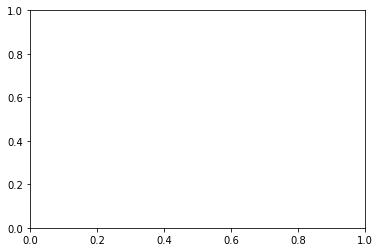

In [12]:
import matplotlib.pyplot as plt
import matplotlib

# plt.style.use('_mpl-gallery')
# plt.figure(figsize=(20,5))
# plot
i=10
fig, ax = plt.subplots()
x = range(0, i+1)
y = Pvd_it
plt.plot(x, y, linewidth=2.0)
fig.set_size_inches(20, 5)

# ax.set(xlim=(0, 8),
#        ylim=(0, 8))
# loc = matplotlib.ticker.LinearLocator(numticks = len(x)-1)
# plt.gca().xaxis.set_major_locator(loc)
ax.set_xticks(x)
plt.show()